# ULTImodel tutorial 1: Create a road network

The first step of calculating ULTImodel is to create the road networks for the respective countries. A road network consists of links and nodes, and it is possible to route on this network as each link is directed, i.e has a dedicated start and end node. The network will be extracted from OSM by using a country's polygon.

There is one input needed: a `Geopandas GeoDataFrame` of the traffic analysis zones (TAZ). In this tutorial, we will use the NUTS 3 classification for Denmark, Sweden, Norway and Finland as TAZ.

## Import packages

In [1]:
# for network creation
from ultimodel import CreateNetwork

In [2]:
import geopandas as gpd
import pandas as pd
from datetime import datetime

## Read input: TAZ

The input includes georeferenced TAZ in `EPSG:4326` with the following _required_ attributes (columns):

* __ID__ | field including a unique ID, e.g. the NUTS ID
* __Country__ | field containing the ISO-2 code of the respective country

Other attributes like name, population etc. can be added, but are not required for the following steps.

In [3]:
# load taz from database or local
taz = gpd.GeoDataFrame.from_file('tutorial-files/_input/taz-tutorial.gpkg')

# defining ID, country and geometry column names of taz
taz_id = "nuts_id"
taz_cn = "cntr_code"
taz_geo = "geometry"

taz.head()

,nuts_id,cntr_code,nuts_name,geometry
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63..."
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62..."
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62..."
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61..."
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62..."


## Create networks

This part will create a simplified OSM network for all roads ranked _primary and higher_ in Denmark. This network will be overlayed with the `taz` layer to split links at zone borders and assign the TAZ ID. Finally, each link gets a unique ID to be used in ULTImodel. Due to the number of items in an area for a whole country, this process takes ~30min to 1h.

The types of roads to be included in the road network can be defined in the methods.

As final result from the network creation there are
* __EDGES__ | The links of the road network, including a unique ID, start and end node, type, speed, length and travel time.
* __NODES__ | The nodes in the network which define the points where a link starts and ends, i.e. can be entered or left. They include a unique ID and a list of connected links.

In [4]:
path_export = 'tutorial-files/tutorial1/'

In [5]:
# ensure that each country has a unique id start
cn_id = 20000000
cn = "DK"
# Start network creation
print(cn)
print("   Create road network from OSM... {}".format(datetime.now()))
network_edges = CreateNetwork.Edges(cn, taz, taz_cn, taz_geo)
# create polygon
polys = network_edges.get_polygon(taz_id=taz_id)
network_edges.get_edges(["motorway", "trunk", "primary"], polys)
network_edges.set_attributes(taz_id, start_id=cn_id)
print("   Network created! {}\n    {} edges".format(datetime.now(), len(network_edges.edges)))
print("   Extract nodes from edges... {}".format(datetime.now()))
network_nodes = CreateNetwork.Nodes(network_edges.edges)
network_nodes.create_nodes("ultimo_id", "geometry")
network_nodes.remove_duplicates()
network_nodes.set_node_id("node_id",start=cn_id)
print("   Nodes extracted! {}\n    {} nodes".format(datetime.now(), len(network_nodes.nodes_unique)))
# add start and end node to edges
network_edges.set_nodes(network_nodes.nodes, order_col="order", linkid_col="LinkID", nodeid_col="node_id")
# add ferry routes to islands if necessary
if len(polys) > 1:
    print("   Find ferry routes and bridges from OSM... {}".format(datetime.now()))
    ferry_cn = CreateNetwork.Ferries(taz, scope=cn, taz_cn=taz_cn, taz_geo=taz_geo)
    ferry_cn.find_ferry_routes(buffer_water=0.01)
    ferry_routes, ferry_nodes = ferry_cn.ferry_national(region_id=taz_id)
    _network = ferry_cn.ferry_to_road(ferry_routes, ferry_nodes, network_edges.edges, network_nodes.nodes_unique, ferry_buffer_m=5000)
    print("   Ferries and bridges added to network... {}".format(datetime.now()))
else:
    _network = network_edges.edges
# Check connectivity and add edges if necessary: all nodes in the network shoulb be connected to each other for routing
final_network, final_nodes = network_edges.connect_subgraphs(network_nodes.nodes_unique, edges=_network)
# save edges and nodes
final_network.to_file(path_export+"{}_e".format(cn)+".gpkg", driver="GPKG")
final_nodes.to_file(path_export+"{}_n".format(cn)+".gpkg", driver="GPKG")
print("   Finished network generation! {}".format(datetime.now()))

DK
   Create road network from OSM... 2023-04-13 17:49:01.140040
   Network created! 2023-04-13 17:49:57.908637
    3558 edges
   Extract nodes from edges... 2023-04-13 17:49:57.908637
   Nodes extracted! 2023-04-13 17:50:14.220400
    2199 nodes
   Find ferry routes and bridges from OSM... 2023-04-13 17:50:14.251648
. . . extracting bridges and ferries from OSM
. . . bridges and ferries extracted!


C:\Users\thom_nn\.conda\envs\ultimodel2\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


No road connection for ferry route 13
no start / end connection for ferry route 1519
   Ferries and bridges added to network... 2023-04-13 17:50:44.253408
Connecting 7 sub graphs...
   Finished network generation! 2023-04-13 17:50:45.434193


## Get subordinate network length per TAZ

In this step, the aggregated length of the _secondary_ road network on cell level is determined and added as an attribute to the `taz` data. This is done to include VKT that is travelled in the subordinate network, which can be an important factor for further processing of the results (e.g. calculating emissions). The type of road can be specified as function parameter.

The result is:

* __TAZ__ | The `taz GeoDataFrame` is updated with the aggregated length of the subordinate road network

In [9]:
print("Aggregate subordinate network length from OSM... {}".format(datetime.now()))
len_per_taz = CreateNetwork.subordinate_road_length(taz[taz[taz_cn] == "DK"].copy(), sub_type='secondary')
print("Finished at {}".format(datetime.now()))
len_per_taz.head()

Aggregate subordinate network length from OSM... 2023-04-13 17:54:07.700163


11it [00:13,  1.24s/it]

Finished at 2023-04-13 17:54:21.393879


,nuts_id,cntr_code,nuts_name,geometry,length_sub
19,DK011,DK,Byen København,"MULTIPOLYGON (((12.50479 55.63734, 12.48025 55...",19.491187
20,DK012,DK,Københavns omegn,"MULTIPOLYGON (((12.24627 55.70664, 12.25874 55...",121.190523
21,DK013,DK,Nordsjælland,"MULTIPOLYGON (((12.24627 55.70664, 12.21994 55...",374.149882
22,DK014,DK,Bornholm,"MULTIPOLYGON (((14.88943 55.22813, 14.94373 55...",62.503512
23,DK021,DK,Østsjælland,"MULTIPOLYGON (((12.24627 55.70664, 12.16537 55...",139.439029


In [10]:
len_per_taz.to_file(path_export+'dk-tutorial-len'+".gpkg", driver="GPKG")

## Result after tutorial1

<Axes: >

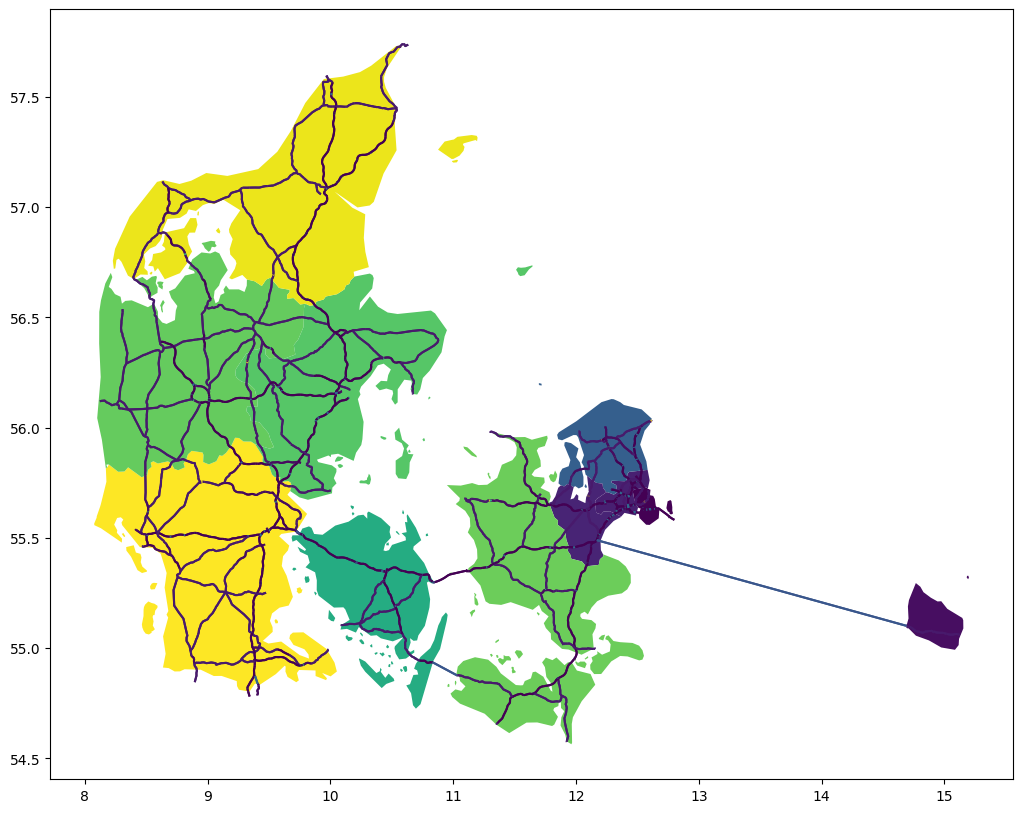

In [8]:
# plot TAZ and roads
ax=len_per_taz.plot(column='length_sub', kind='geo', figsize=(20,10))
final_network.plot(ax=ax, column='type', kind='geo')

Looking at multiple countries, the process can be performed as a loop over the unique countries in `taz`.

**WARNING** This takes multiple hours due to the amount of requests.

In [4]:
countries = taz[taz_cn].unique()

In [ ]:
# id counter: ensure that each country has a unique id start
cn_id = 10000000
# include islands and ferries
# iteration
for i, cn in enumerate(countries):
    print(cn)
    print("   Create road network from OSM... {}".format(datetime.now()))
    network_edges = CreateNetwork.Edges(cn, taz, taz_cn, taz_geo)
    # create polygon
    polys = network_edges.get_polygon(taz_id=taz_id)
    network_edges.get_edges(["motorway", "trunk", "primary"], polys)
    network_edges.set_attributes(taz_id, start_id=cn_id)
    print("   Network created! {}\n    {} edges".format(datetime.now(), len(network_edges.edges)))
    print("   Extract nodes from edges... {}".format(datetime.now()))
    network_nodes = CreateNetwork.Nodes(network_edges.edges)
    network_nodes.create_nodes("ultimo_id", "geometry")
    network_nodes.remove_duplicates()
    network_nodes.set_node_id("node_id",start=cn_id)
    print("   Nodes extracted! {}\n    {} nodes".format(datetime.now(), len(network_nodes.nodes_unique)))
    # add start and end node to edges
    network_edges.set_nodes(network_nodes.nodes, order_col="order", linkid_col="LinkID", nodeid_col="node_id")
    # add ferry routes to islands if necessary
    if len(polys) > 1:
        print("   Find ferry routes and bridges from OSM... {}".format(datetime.now()))
        ferry_cn = CreateNetwork.Ferries(taz, scope=cn, taz_cn=taz_cn, taz_geo=taz_geo)
        ferry_cn.find_ferry_routes(buffer_water=0.01)
        ferry_routes, ferry_nodes = ferry_cn.ferry_national(region_id=taz_id)
        _network = ferry_cn.ferry_to_road(ferry_routes, ferry_nodes, network_edges.edges, network_nodes.nodes_unique, ferry_buffer_m=5000)
        print("   Ferries and bridges added to network... {}".format(datetime.now()))
    else:
        _network = network_edges.edges
    # Check connectivity and add edges if necessary: all nodes in the network shoulb be connected to each other for routing
    final_network, final_nodes = network_edges.connect_subgraphs(network_nodes.nodes_unique, edges=_network)
    # save edges and nodes
    final_network.to_file(path_export+"{}_e".format(cn)+".gpkg", driver="GPKG")
    final_nodes.to_file(path_export+"{}_n".format(cn)+".gpkg", driver="GPKG")
    print("   Finished network generation! {}".format(datetime.now()))
    cn_id += 1000000

For subordinate network length, it is possible to include all taz for all regarded countries in the function.

**WARNING** Due to the large area covered, this takes multiple hours!

In [7]:
print("Aggregate subordinate network length from OSM... {}".format(datetime.now()))
len_per_taz = CreateNetwork.subordinate_road_length(taz, taz_id, sub_type='secondary')
print("Finished at {}".format(datetime.now()))
len_per_taz.head()

Aggregate subordinate network length from OSM... 2023-03-17 09:22:34.410986


69it [16:47:19, 875.94s/it] 

Finished at 2023-03-18 02:09:54.189676


,nuts_id,cntr_code,nuts_name,geometry,length_sub
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63...",1130.241897
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62...",871.008000
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62...",607.585794
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61...",498.395849
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62...",974.549378


<Axes: >

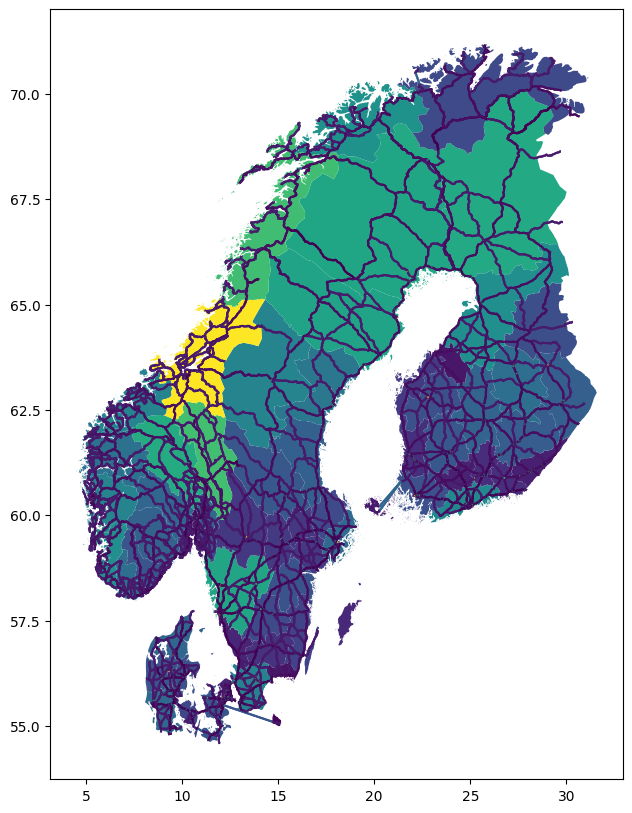

In [9]:
# read results
for i,cn in enumerate(countries):
    # get roads
    net = gpd.GeoDataFrame.from_file(path_export +'{}_e'.format(cn)+'.gpkg')
    net.crs=4326
    if i == 0:
        net_all=net.copy()
    else:
        net_all = pd.concat([net_all, net])
    del net
# plot TAZ and roads
ax=len_per_taz.plot(column='length_sub', kind='geo', figsize=(20,10))
net_all.plot(ax=ax, column='type', kind='geo')